**Name: Yutika Rege**

**Date: 25-07-2021**

**PRN: 1901202012**

**School: Data Science**

**Program: B.Sc. Data Science**

**Year/ Semester: 2nd / 4th**

**Subject Name: Machine Learning 2**

**Subject Code: DS401**

**Title: Time Series Analysis.**

**Skills/Competencies to be acquired:**

1. Time series analysis and modelling.

2. Trend visualisation.

3. ARIMA model fitting.

4. Data cleaning, EDA and Feature engineering.

**Duration of activity: 2 Hours**

**1. What is the purpose of this activity?**

The purpose of this activity is to fit an ARIMA time series model and perform time series analysis to forecast sales of the furniture category of the "Superstore" data.

**2. Steps performed in this activity.**

1. Import the required modules and read the data.

2. Perform statistical as well as visual EDA over the data.

3. Do the necessary feature engineering to produce useful inputs.

4. Selection of the ideal parameters via grid search and using them to produce an ARIMA model which has the lowest Akaike Info. Criterion; thereby visualising the forecast of furniture sales.

5. Compare the trend of furniture with the other categories - office supplies and technology.

-------------------------------------------------------------------------------------------------------------------------------

**Importing modules:**

In [8]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [9]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

**Feature engineering:** For visualizing furniture sales time series data, we will only be using two columns - 'Order Date' and 'Sales' and for this purpose, we will be sorting the data as per the order date and then converting it into index. After that we will use the averages daily sales value for that month instead because the current datetime data can be tricky to work with, and now we are using the start of each month as the timestamp.

# Furniture:

In [10]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 
        'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')

furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [11]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [12]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [13]:
y = furniture['Sales'].resample('MS').mean()

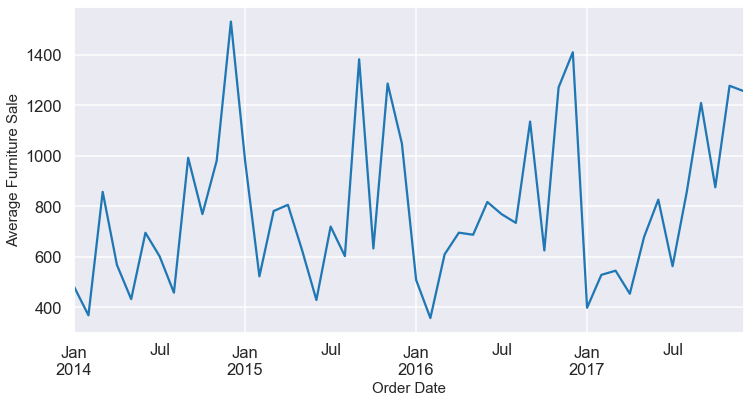

In [40]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
y.plot(figsize=(12, 6))
plt.ylabel("Average Furniture Sale",size=15)
plt.xlabel("Order Date",size=15)
plt.show()

**Comment:** The trend seen here is seasonal in nature.This trend is seen in every year. The peak sales are in the month of January in the year 2015 and then a sudden plummet mid-year. The lowest sales were observed in the April 2017 with an immediate increase in the month of June. Overall, It can be seen that at the beginning of the year, there are very less sales but as the year progresses, there is a positive (upward) trend with a few plummets here and there.

**The decomposed version (model type = additive (o=t+s+r)):**

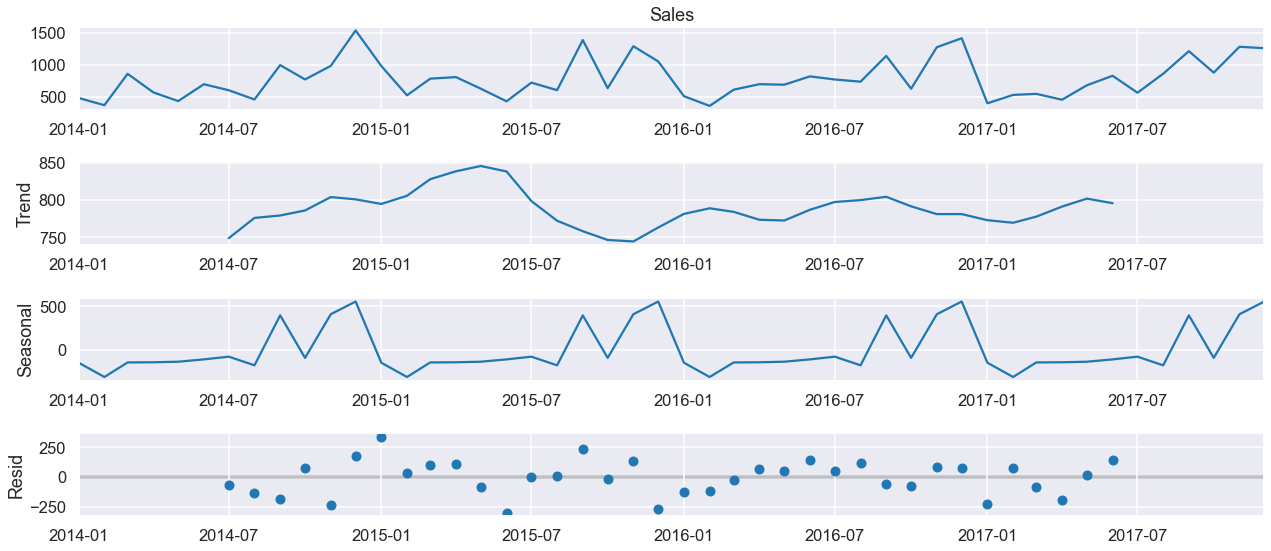

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Forecasting of Furniture Sales using _ARIMA_ :

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [19]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [20]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [21]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1264.304674587017
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899929659
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1111.6965010969373
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280367359
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.925227075812
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2965.7144602691324
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091437
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673033
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.53555378588703
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1378388170206
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876927765
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576530882
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1033.7086168707388
ARIMA(

**Comment:** The ideal parametes were found out to be - pdq combo of (1,1,1) and the ideal seasonal pdq combo of (0,1,1,12) which gave an overall low Akaike Info Criterion (AIC) score of 281.38. We will thus fit another model with those parameters.

In [22]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0953      0.310     -0.307      0.759      -0.703       0.513
ma.L1         -1.0000      0.414     -2.417      0.016      -1.811      -0.189
ma.S.L12      -0.3049      0.172     -1.777      0.076      -0.641       0.031
sigma2      2.476e+04   1.67e-05   1.48e+09      0.000    2.48e+04    2.48e+04


We should always run model diagnostics to investigate any unusual behavior.

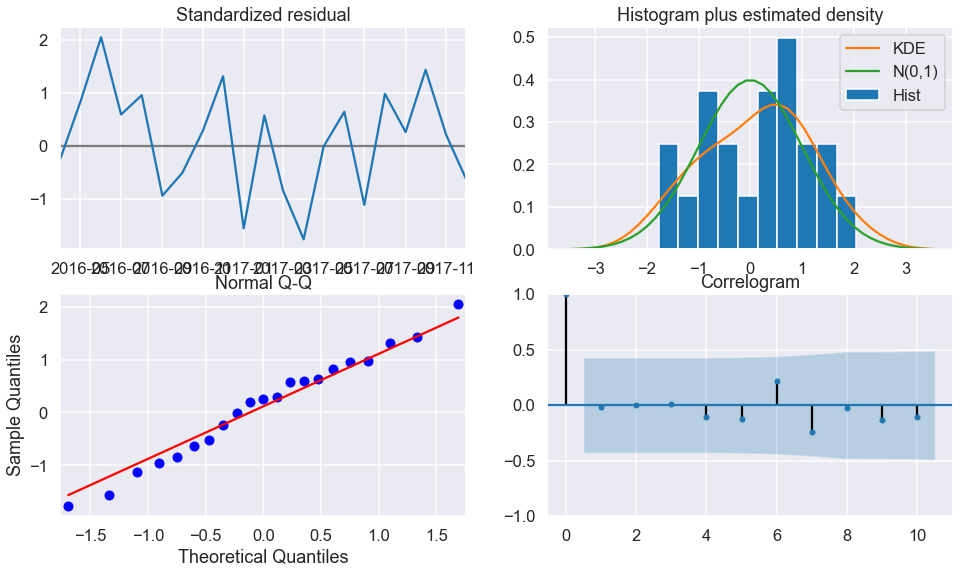

In [43]:
results.plot_diagnostics(figsize=(16,9))
plt.show()

**Comment:** The model diagnostics suggests that the model residuals are near normally distributed.

**Validating forecasts:**

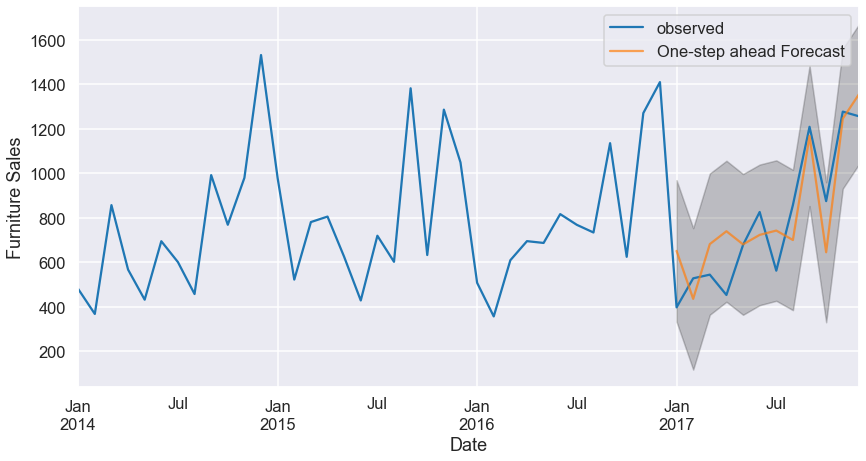

In [44]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

**Comment:** The forecasts somewhat align with the true values,showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [25]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 25665.13


In [26]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 160.2


**Comment:** Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 160.2 of the real sales. 

**Visualizing forecasts:**

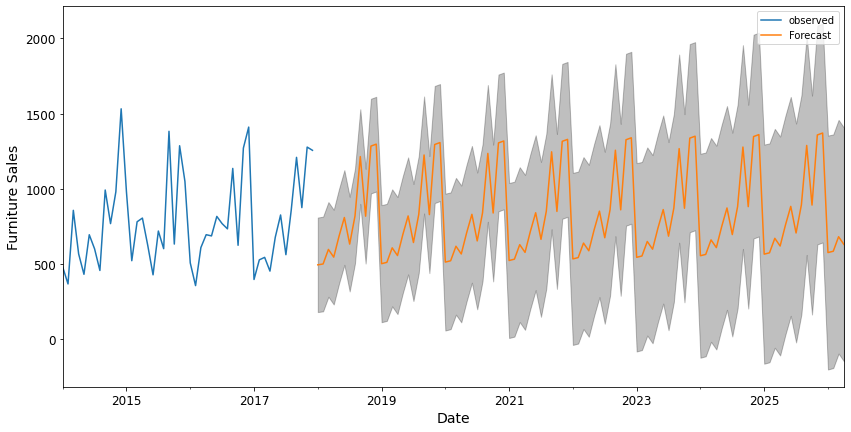

In [27]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

**Comment:** With the plot above, the trend of the forecast values is the same as our usual trend; less sales in the beginning of the year and the gradual increase over the year (with a few plummets over the months).

# Furniture v/s Office supplies:

In [34]:
office = df.loc[df['Category'] == 'Office Supplies']

In [35]:
office.drop(cols, axis=1, inplace=True)

office = office.sort_values('Order Date')

office.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [36]:
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [37]:
office = office.set_index('Order Date')
y_off = office['Sales'].resample('MS').mean()

In [38]:
furniture = pd.DataFrame({'Order Date':y.index, 'Sales':y.values})
office = pd.DataFrame({'Order Date': y_off.index, 'Sales': y_off.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


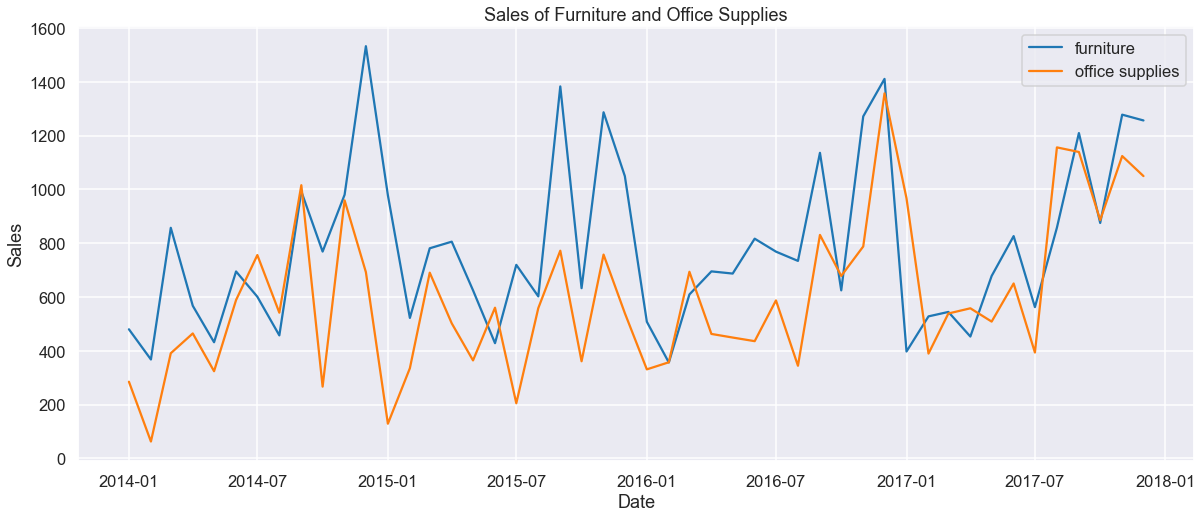

In [45]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); 
plt.title('Sales of Furniture and Office Supplies')
plt.legend();

**Comment:** The trend of office supplies and furniture is pretty similar trends; low sales in the beginning then increase towards the end of the year. However, from our knowledge it is established that the "prices" of office supplies tend to be lower than furniture but there are a few days where the sales of office supplies is more than furniture. This can be due to the quantum of the office supplies sold as well.

# Furniture v/s Technology:

In [48]:
tech = df.loc[df['Category'] == 'Technology']

In [49]:
tech.drop(cols, axis=1, inplace=True)

tech = tech.sort_values('Order Date')

tech.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [50]:
tech = tech.groupby('Order Date')['Sales'].sum().reset_index()

In [51]:
tech = tech.set_index('Order Date')
y_tech = tech['Sales'].resample('MS').mean()

In [52]:
tech = pd.DataFrame({'Order Date': y_tech.index, 'Sales': y_tech.values})
store1 = furniture.merge(tech, how='inner', on='Order Date')
store1.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store1.head()

,Order Date,furniture_sales,technology_sales
0,2014-01-01,480.194231,449.041429
1,2014-02-01,367.931600,229.787143
2,2014-03-01,857.291529,2031.948375
3,2014-04-01,567.488357,613.028933
4,2014-05-01,432.049188,564.698588


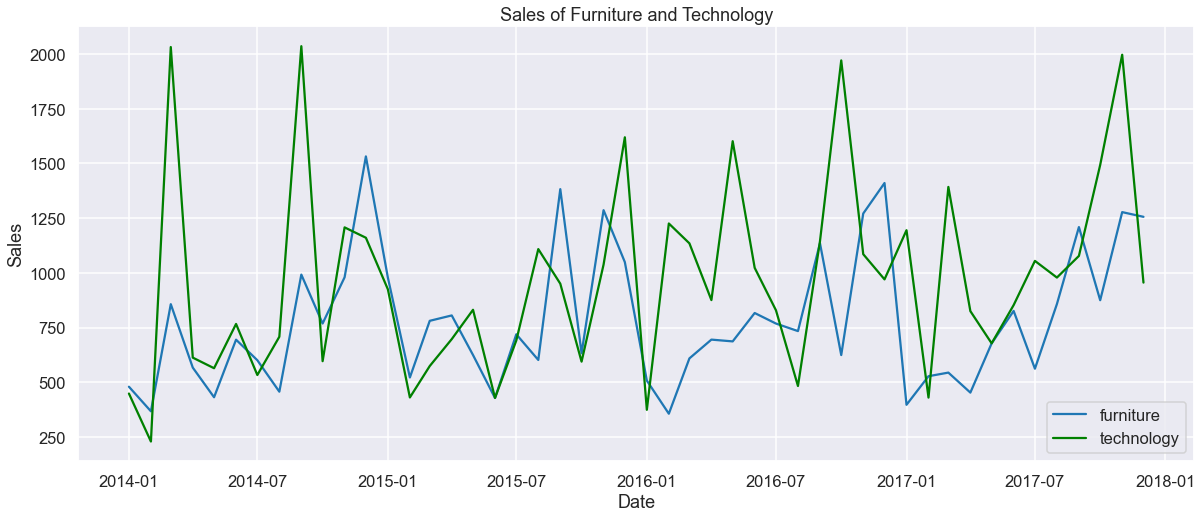

In [53]:
plt.figure(figsize=(20, 8))
plt.plot(store1['Order Date'], store1['furniture_sales'], label = 'furniture')
plt.plot(store1['Order Date'], store1['technology_sales'], label = 'technology',c='g')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Technology')
plt.legend();

**Comment:** The sales of technology seem to be higher than furniture but with the same trend as that observed in office supplies and furniture.